# Imports

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 2.9MB/s 


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential
import tensorflow_hub as hub

import re
import tokenization
import string
import os
"""
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Flatten
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
"""
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Cargar data

In [ ]:
data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
to_predict = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

3263

# Preparacion

3271 4342


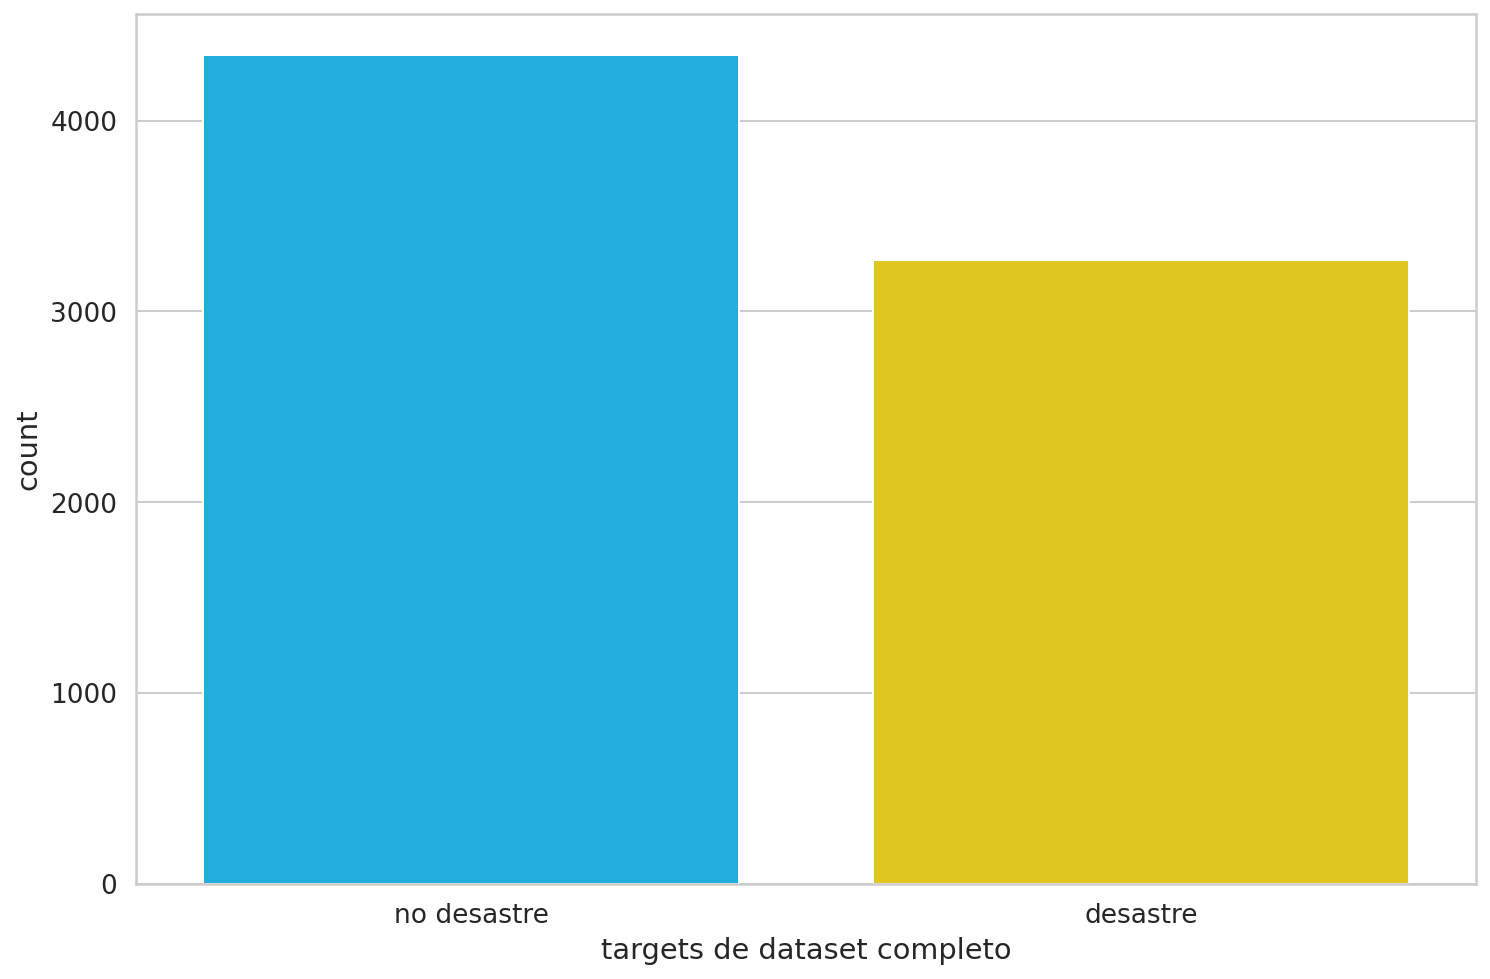

In [ ]:
data['complete_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

tag_1 = data[data['target'] == 1]
tag_0 = data[data['target'] == 0]


ax = sns.countplot(data.target)
plt.xlabel('targets de dataset completo')
ax.set_xticklabels(['no desastre','desastre']);
print(len(tag_1),len(tag_0))

In [ ]:
#Esto es para que el set de train y val este equilibrado entre 1 y 0 y para que el 
#set de validacion tenga solo datos nuevos que no se usaron en train 

tag_1_val_size = 0.1

tag_0_val_size = 1 - (len(tag_1) * (1 - tag_1_val_size))/(len(tag_0))

tag_1_train, tag_1_val = train_test_split(tag_1, test_size = tag_1_val_size)
tag_0_train, tag_0_val = train_test_split(tag_0, test_size = tag_0_val_size)

tag_0_val = tag_0_val.sample(len(tag_1_val))

train = pd.concat([tag_1_train,tag_0_train])
val = pd.concat([tag_1_val,tag_0_val])
len(train),len(val)

(5886, 656)

# Encodeo de tweets para la red neuronal

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, False)

porcentaje de tweets que quedan cortados: 0.01%


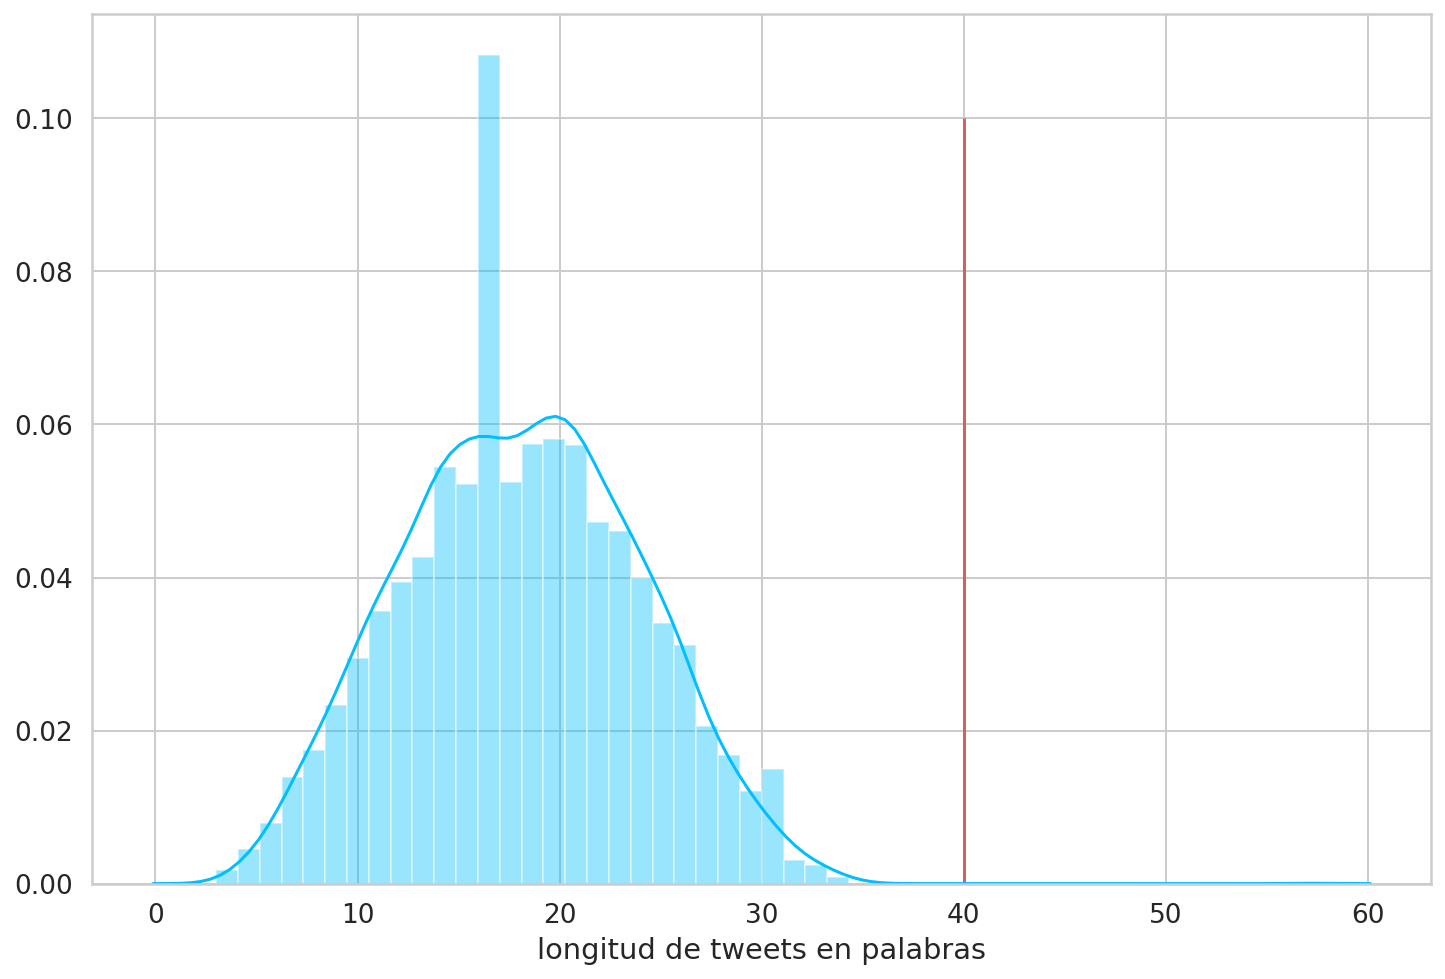

In [ ]:
# La red requiere una longitud maxima y mas rapido entrena 
#cuando mas corta es la longitud por lo que estoy buscando con que longitud 
#maxima quedarme sin tirar demasiados tweets

MAX_LEN = 180

lens = data.complete_text.apply(lambda x: len(x)) )

sns.distplot(lens)
plt.xlabel('longitud de tweets');
plt.vlines(x=MAX_LEN, ymin=0, ymax=0.1,  color = 'r')

print("porcentaje de tweets que quedan cortados: {}%".format(round(len(lens[ lens > MAX_LEN ])/len(data) * 100,2)))

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


x_train = bert_encode(train.complete_text.values, tokenizer, max_len=MAX_LEN)
x_val = bert_encode(val.complete_text.values, tokenizer, max_len=MAX_LEN)
x_to_predict = bert_encode(to_predict.complete_text.values, tokenizer, max_len=MAX_LEN)
y_train = train.target.values
y_val = val.target.values

# Creacion de modelo

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = build_model(bert_layer, max_len=MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

# Entrenando modelo

In [ ]:
TRIAL = 0

In [ ]:
checkpoint = ModelCheckpoint(filepath=str(TRIAL)+'.h5', monitor='val_accuracy', save_best_only=True, verbose = 1)

Epoch 1/5
368/368 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.7931
Epoch 00001: val_accuracy improved from -inf to 0.83384, saving model to 0.h5
368/368 [==============================] - 383s 1s/step - loss: 0.4540 - accuracy: 0.7931 - val_loss: 0.3941 - val_accuracy: 0.8338
Epoch 2/5
368/368 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8801
Epoch 00002: val_accuracy improved from 0.83384 to 0.84146, saving model to 0.h5
368/368 [==============================] - 378s 1s/step - loss: 0.3024 - accuracy: 0.8801 - val_loss: 0.3993 - val_accuracy: 0.8415
Epoch 3/5
368/368 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9242
Epoch 00003: val_accuracy did not improve from 0.84146
368/368 [==============================] - 345s 938ms/step - loss: 0.1964 - accuracy: 0.9242 - val_loss: 0.5386 - val_accuracy: 0.8186
Epoch 4/5
368/368 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9619
Epoch 0

(0.0, 1.0)

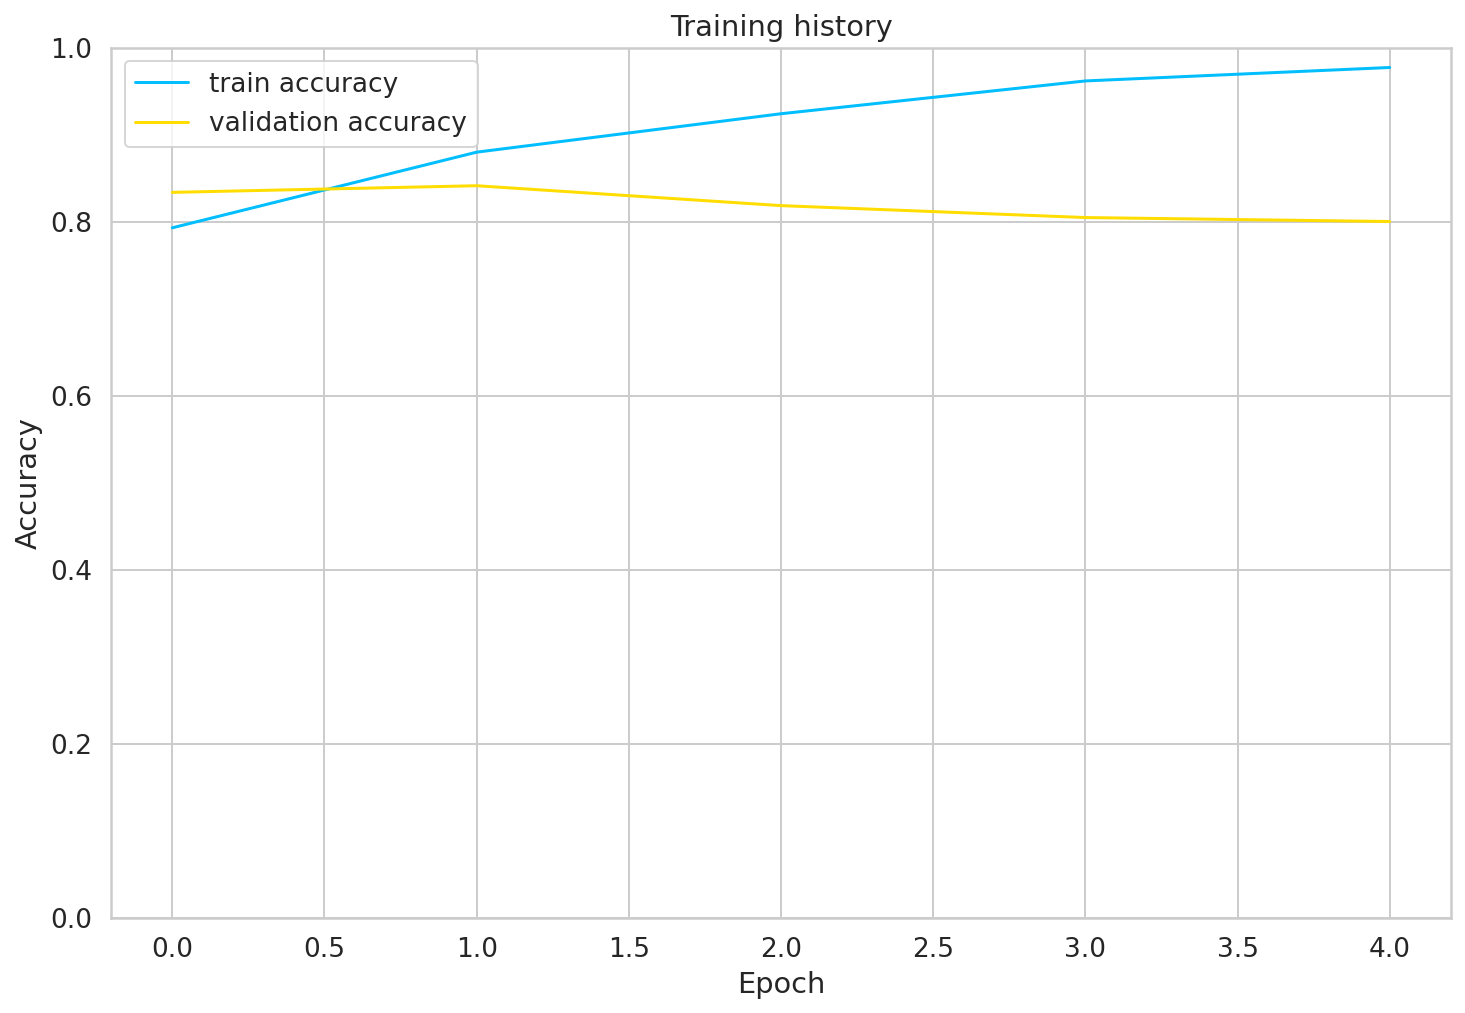

In [ ]:
history = model.fit(x_train,y_train, epochs=5, validation_data=(x_val,y_val),
                    callbacks=[checkpoint],batch_size=16)
TRIAL += 1


plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

(0.0, 1.0)

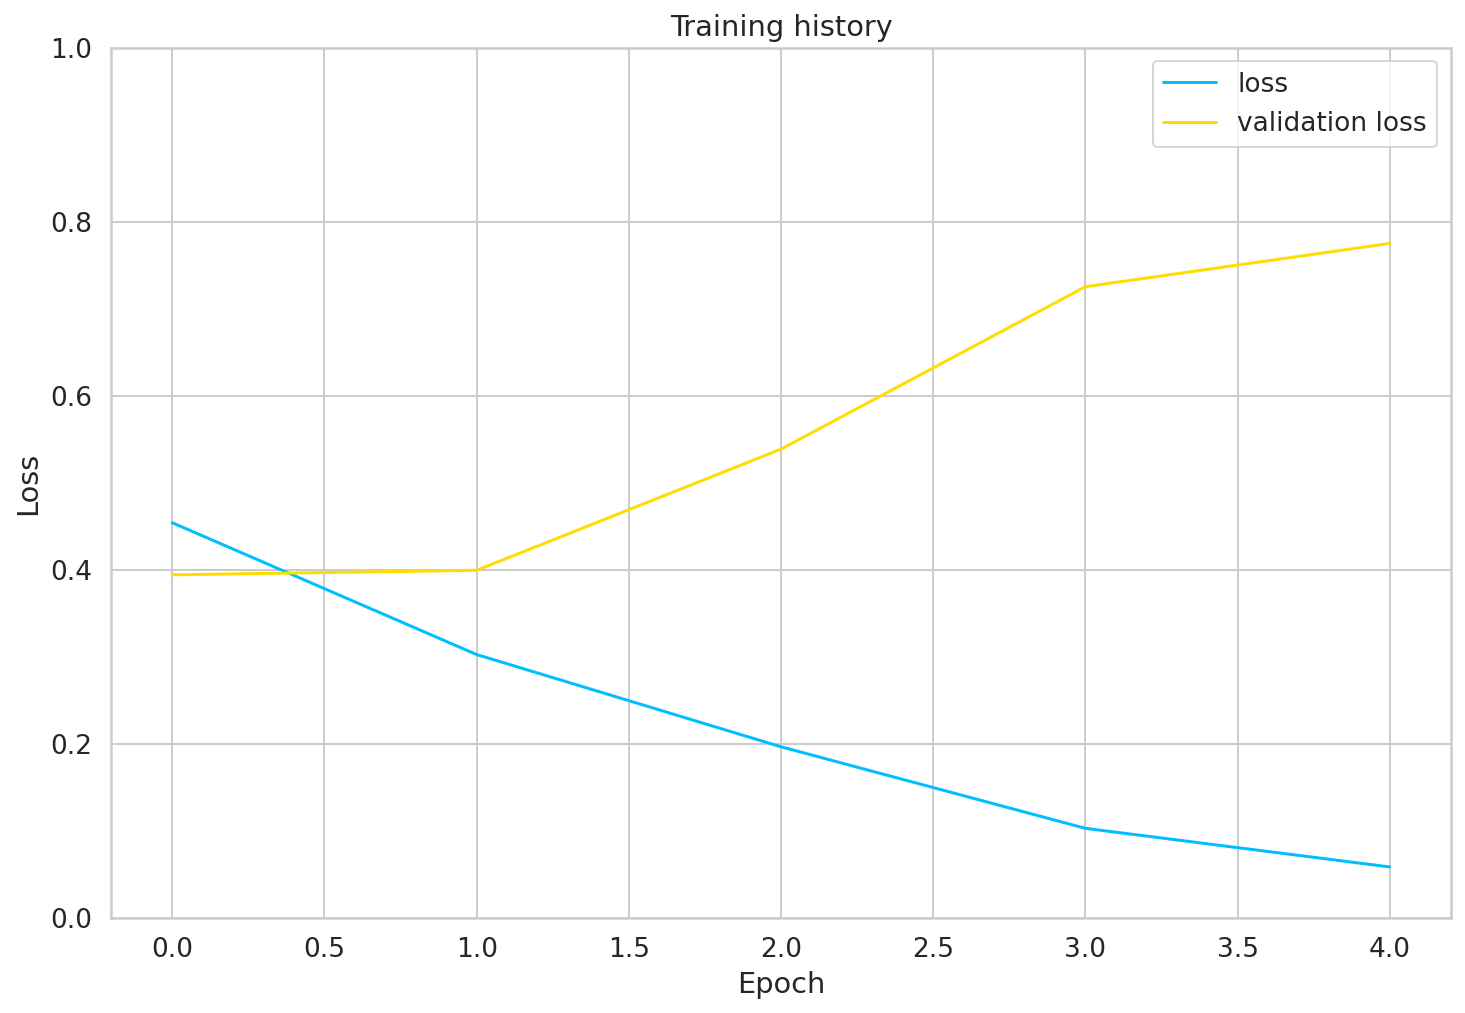

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# Evaluacion

In [ ]:
model.load_weights(str(TRIAL - 1)+'.h5')
preds = model.predict(x_val)

In [ ]:
mapProbs = lambda x: 1 if x>=0.5 else 0

In [ ]:
real_preds = []
for p in preds:
    real_preds.append(mapProbs(p))

In [ ]:
print(metrics.classification_report(y_val, real_preds,zero_division = 0))
print('F1 score: ',metrics.f1_score(y_val, real_preds, zero_division = 0))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       328
           1       0.88      0.79      0.83       328

    accuracy                           0.84       656
   macro avg       0.84      0.84      0.84       656
weighted avg       0.84      0.84      0.84       656

F1 score:  0.8333333333333334


In [ ]:
preds = model.predict(x_to_predict)
real_preds = []
for p in preds:
    real_preds.append(mapProbs(p))

In [ ]:
submit = pd.DataFrame({
    'id': list(to_predict.id),
    'target': real_preds
})
submit

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
submit.to_csv('BERT_keras_2.csv')